/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1463, number of negative: 6511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 7974, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183471 -> initscore=-1.493004
[LightGBM] [Info] Start training from score -1.493004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model AUC Scores: {'Random Forest': np.float64(0.9999144077012929), 'XGBoost': np.float64(0.999947973308629), 'LightGBM': np.float64(0.9999429384675287)}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


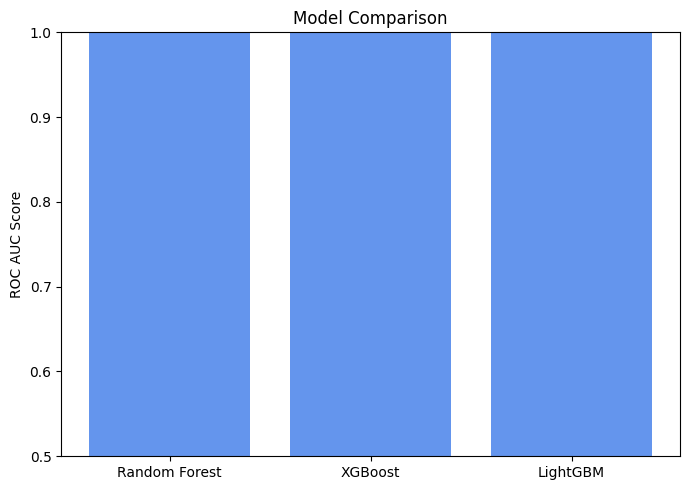

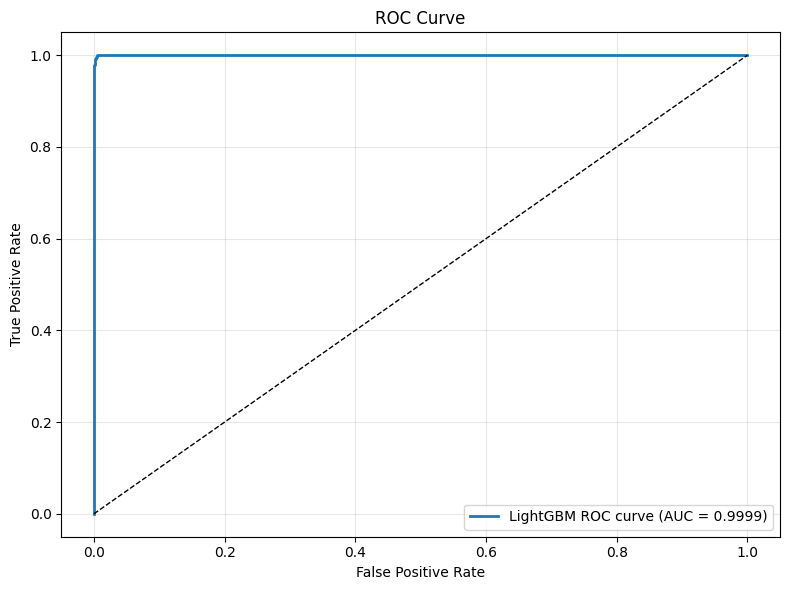

/tmp/ipython-input-2-3217115039.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='default', y='income_stability', palette='Set2')


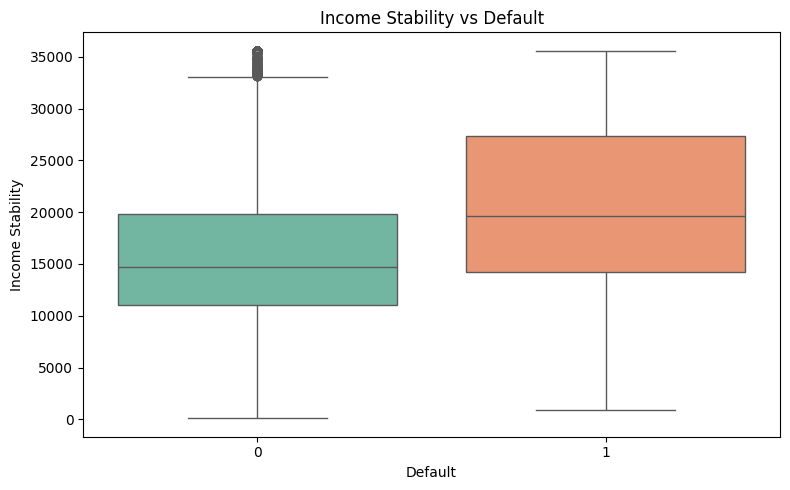

Expected Loss: 10799.41


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'loan_amt_outstanding': 'loan_amount', 'fico_score': 'credit_score'}, inplace=True)


numeric_cols = ['income', 'loan_amount', 'credit_lines_outstanding', 'total_debt_outstanding',
                'years_employed', 'credit_score', 'default']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['income'] = df['income'].replace(0, np.nan)
df.dropna(subset=numeric_cols, inplace=True)


df['debt_to_income'] = df['loan_amount'] / df['income']
df['credit_utilization'] = df['loan_amount'] / df['total_debt_outstanding']
df['income_stability'] = df['income'] / df['years_employed']
df['risk_score'] = df['credit_score'] / df['years_employed']
df['normalized_debt_load'] = df['total_debt_outstanding'] / df['income']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

def cap_outliers(df, cols):
    for col in cols:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df[col] = np.clip(df[col], lower, upper)
    return df

cap_cols = ['income', 'loan_amount', 'total_debt_outstanding', 'credit_score',
            'debt_to_income', 'credit_utilization', 'income_stability', 'risk_score',
            'normalized_debt_load']
df = cap_outliers(df, cap_cols)


features = ['income', 'loan_amount', 'credit_lines_outstanding', 'total_debt_outstanding',
            'years_employed', 'credit_score', 'debt_to_income', 'credit_utilization',
            'income_stability', 'risk_score', 'normalized_debt_load']
X = df[features]
y = df['default']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:, 1]

xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict_proba(X_test)[:, 1]


roc_scores = {
    'Random Forest': roc_auc_score(y_test, rf_pred),
    'XGBoost': roc_auc_score(y_test, xgb_pred),
    'LightGBM': roc_auc_score(y_test, lgb_pred)
}
print("Model AUC Scores:", roc_scores)


plt.figure(figsize=(7, 5))
plt.bar(roc_scores.keys(), roc_scores.values(), color='cornflowerblue')
plt.ylabel("ROC AUC Score")
plt.title("Model Comparison")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, lgb_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM ROC curve (AUC = {roc_auc:.4f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='default', y='income_stability', palette='Set2')
plt.title("Income Stability vs Default")
plt.xlabel("Default")
plt.ylabel("Income Stability")
plt.tight_layout()
plt.show()


def estimate_expected_loss(model, loan_features, recovery_rate=0.10):
    income = loan_features[0]
    loan_amount = loan_features[1]
    if income == 0 or pd.isnull(income) or pd.isnull(loan_amount):
        return "Invalid input"
    debt_to_income = loan_amount / income
    credit_utilization = loan_amount / loan_features[3]
    income_stability = income / loan_features[4]
    risk_score = loan_features[5] / loan_features[4]
    normalized_debt_load = loan_features[3] / income

    full_features = loan_features + [debt_to_income, credit_utilization,
                                     income_stability, risk_score, normalized_debt_load]
    scaled_input = scaler.transform([full_features])
    pd_value = model.predict_proba(scaled_input)[0][1]
    expected_loss = pd_value * (1 - recovery_rate) * loan_amount
    return round(expected_loss, 2)


sample_loan = [55000, 12000, 3, 20000, 5, 700]  # income, loan_amt, credit_lines, debt, years, score
loss = estimate_expected_loss(lgb_model, sample_loan)
print("Expected Loss:", loss)

In [4]:
!ls

 sample_data  'Task 3 and 4_Loan_Data.csv'
